# Meta model

## Load required modules and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC




In [2]:
import pickle

In [3]:
import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

### Settings

In [40]:
# default plt figuresize, smallish
plt.rcParams["figure.figsize"] = (6,3)

## Load and prepare the data

In [4]:
### Load dataset
data = datasets.data_original()
### Feature engineering 
data = features.engineer(data)
### Train test split (unprocessed)
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Scaling the data 

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test_.columns)



## Load and evaluate all models

In [53]:
models = {}

### Logistic regression

In [55]:
models["Logistic"] = pickle.load(open("models/logistic_RFE9.pkl", "rb"))

In [11]:
n_features = models["Logistic"].coef_.shape[1]
n_features

9

In [47]:
rfe_features = pickle.load(open("models/rfe_features_250103.pkl", "rb"))[9]

In [61]:
print(rfe_features)

['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored']


### Random Forest

In [63]:
with open("models/random_forest_gridsearch_241218.pkl", "rb") as file:
    models["RandomForest"] = pickle.load(file)

## Evaluate the models

In [64]:

y_train = y_train_
y_test = y_test_

y_pred_train = {}
y_proba_train = {}

y_pred_test = {}
y_proba_test = {}

### Data preprocessing

In [74]:
# by default we assing unscaled raw data to each model
X_train_preprocessed = {modelname: X_train_ for modelname in models}
X_test_preprocessed = {modelname: X_test_ for modelname in models}



In [75]:
# Logistic : scaled dataset, with only selected features
X_train_preprocessed["Logistic"] = X_train_scaled[rfe_features]
X_test_preprocessed["Logistic"] = X_test_scaled[rfe_features]


### Evaluate all models

In [76]:
for model_name in models:
    model = models[model_name]

    X_train = X_train_preprocessed[model_name]
    y_pred_train[model_name] = model.predict(X_train)
    y_proba_train[model_name] = model.predict_proba(X_train)[:,1]

    X_test = X_test_preprocessed[model_name]
    y_pred_test[model_name] = model.predict(X_test)
    y_proba_test[model_name] = model.predict_proba(X_test)[:,1]

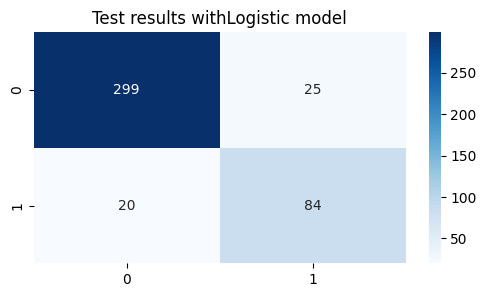

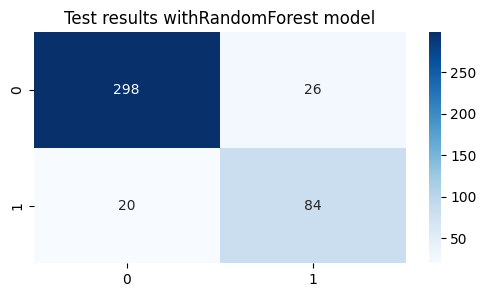

In [ ]:
for model_name in models:
    sns.heatmap(confusion_matrix(y_test,y_pred_test[model_name]), annot = True, cmap = "Blues", fmt='d')
    plt.title("Test results with " + model_name + " model")
    plt.show()


### Evaluation scores


In [125]:
results_test_models_list = []

for model_name in models : 
    y_pred = y_pred_test[model_name]

    results_test = {
        "model": model_name,
        "accuracy": accuracy_score(y_test,y_pred),
        "recall": recall_score(y_test,y_pred),
        "selectivity": recall_score(y_test,y_pred,pos_label = 0),
        "f1": f1_score(y_test,y_pred),
        "f3": fbeta_score(y_test,y_pred,beta = 3),
        "precision": precision_score(y_test,y_pred),
        "NPV": precision_score(y_test,y_pred, pos_label = 0)
    }

    results_test_models_list.append(results_test)

results_test_models_df = pd.DataFrame(results_test_models_list)


In [86]:
print(results_test_models_df)

          model  accuracy    recall  selectivity        f1        f3  \
0      Logistic  0.894860  0.807692     0.922840  0.788732  0.803828   
1  RandomForest  0.892523  0.807692     0.919753  0.785047  0.803059   

   precision       NPV  
0   0.770642  0.937304  
1   0.763636  0.937107  


## Meta model

### Stack the model evaluations

For each patient we evaluate each model with the probability of being infected

In [90]:
X_train_stacked = pd.DataFrame(y_proba_train)
X_test_stacked = pd.DataFrame(y_proba_test)

print(X_train_stacked.shape, X_test_stacked.shape)

(1711, 2) (428, 2)


In [91]:
X_train_stacked.head()

,Logistic,RandomForest
0,0.002483,0.071812
1,0.653643,0.770886
2,0.354624,0.075265
3,0.295284,0.260754
4,0.022432,0.081327


### Visualize the stacked evaluations of the base models

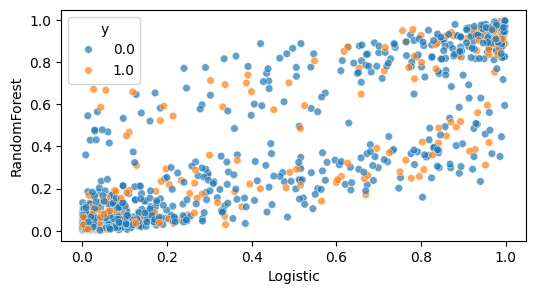

In [108]:
### a simple scatterplot

base_model_scatter = X_train_stacked.copy()
base_model_scatter['y'] = y_train

sns.scatterplot(data=base_model_scatter, x='Logistic', y='RandomForest', hue='y', alpha = 0.7, s=30)
plt.show()

### Logit transform the stacked model

The evaluations of the models are expressed as probabilities, so in $[0,1]$. We want to transform them into log-odd ratios to $[-\infty,\infty]$ via the logit function

In [114]:
def logit(X):
    epsilon = 1e-6
    X_clipped = np.clip(X, epsilon, 1 - epsilon)
    return np.log(X_clipped / (1 - X_clipped))

In [115]:
X_train_stacked_logodd = X_train_stacked.apply(logit)
X_test_stacked_logodd = X_test_stacked.apply(logit)

### Train the meta model

In [138]:
from sklearn.naive_bayes import GaussianNB

meta_classifier = GaussianNB()

meta_classifier.fit(X_train_stacked_logodd,y_train)

GaussianNB()

### Evaluate the meta model

In [139]:
results_test_models_list_meta = results_test_models_list.copy()


y_pred = meta_classifier.predict(X_test_stacked_logodd)

results_test = {
    "model": "meta",
    "accuracy": accuracy_score(y_test,y_pred),
    "recall": recall_score(y_test,y_pred),
    "selectivity": recall_score(y_test,y_pred,pos_label = 0),
    "f1": f1_score(y_test,y_pred),
    "f3": fbeta_score(y_test,y_pred,beta = 3),
    "precision": precision_score(y_test,y_pred),
    "NPV": precision_score(y_test,y_pred, pos_label = 0)
}

results_test_models_list_meta.append(results_test)

results_test_models_df_meta = pd.DataFrame(results_test_models_list_meta)

In [166]:
y_pred_test_meta = y_pred

In [135]:
results_test_models_df_meta

,model,accuracy,recall,selectivity,f1,f3,precision,NPV
0,Logistic,0.894860,0.807692,0.922840,0.788732,0.803828,0.770642,0.937304
1,RandomForest,0.892523,0.807692,0.919753,0.785047,0.803059,0.763636,0.937107
2,meta,0.897196,0.836538,0.916667,0.798165,0.828571,0.763158,0.945860


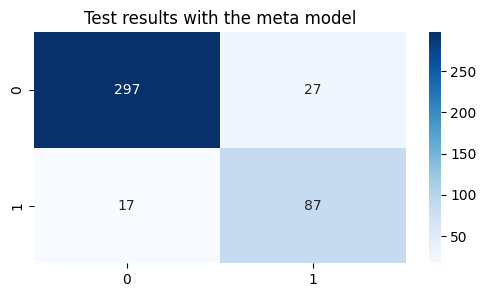

In [167]:
sns.heatmap(confusion_matrix(y_test,y_pred_test_meta), annot = True, cmap = "Blues", fmt='d')
plt.title("Test results with the meta model")
plt.show()

## Visualize decision boundary with two base models

In [164]:
# let's boundary plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_decision_boundary(fitted_meta_model, Xstackedtrain, ytrain, figsize = (10,6)):
    """
    np2darray.ravel() efficiently flattens the array
    np.c_ is like clumn_stack: it acts as zip(), into a 2d array
    """
    df = Xstackedtrain.copy()
    df['y'] = ytrain

    # Create a meshgrid of points
    ## xx.shape == (M,N) where M,N are the number of gridpoints nd the X/Y axis respectively
    x_min, x_max, y_min, y_max = -11, 7.5, -7, 7
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

    ## xx.ravel().shape == (M*N,)
    ## xy.shape = (M*N,2)
    xy = np.c_[xx.ravel(), yy.ravel()]   
    xy = pd.DataFrame(xy,columns = models.keys())  
    
    # Predict on the grid
    Z = meta_classifier.predict(xy)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=figsize)
    ## scatterplot the base model predictions
    sns.scatterplot(data=df, x='Logistic', y='RandomForest', hue='y', s= 30, alpha = 0.6)
    ## countrouf the meta model prediction
    plt.contourf(xx, yy, Z, alpha=0.2, levels=1)
    plt.title("Decision boundary of the meta model")
    plt.show()

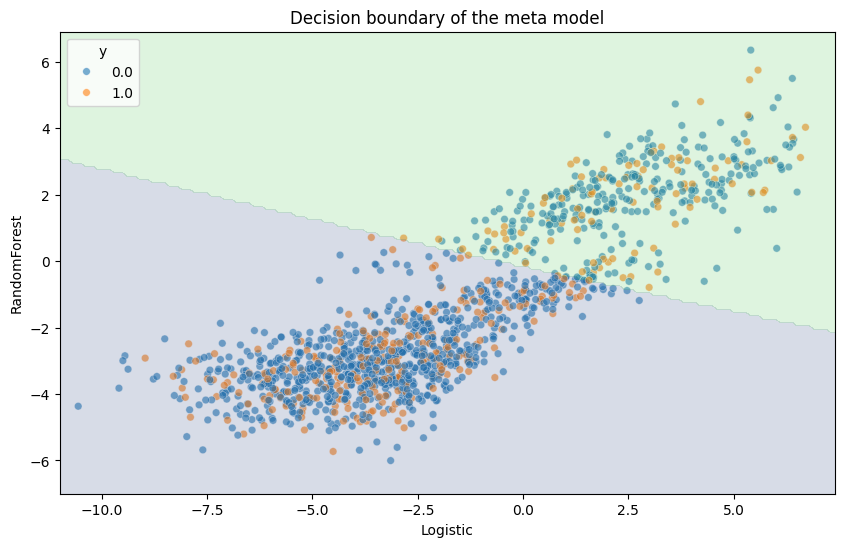

In [165]:
plot_decision_boundary(meta_classifier, X_train_stacked_logodd, y_train)
